In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os
from sklearn.preprocessing import MinMaxScaler
import scipy.io as sio
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os
import scipy.io as sio
import datetime
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp
from scipy.stats import iqr
from scipy.stats import wilcoxon, spearmanr
from statsmodels.stats.descriptivestats import sign_test
import calendar
import pickle

In [2]:
def f_acti(x):
    if (x >= 6) and (x <= 12):
        return 'Morning'
    elif (x >12) and (x <= 18 ):
        return 'Afternoon'
    elif (x > 18) and (x <= 24 ):
        return 'Evening'

def auc (cgm_val, idx0, t1, min_t_diff):
    
    idx_f = idx0 + t1
    
    cgm_diff = cgm_val[idx_f: idx_f+9] - cgm_val[idx_f]
    cgm_diff[cgm_diff<= 0] = 0
    auc_f2 = np.trapz(cgm_diff, dx=15)
    
    cgm_diff = cgm_val[idx_f: idx_f+13] - cgm_val[idx_f]
    cgm_diff[cgm_diff<= 0] = 0
    auc_f3 = np.trapz(cgm_diff, dx=15)
    
    cgm_diff = cgm_val[idx_f: idx_f+17] - cgm_val[idx_f]
    cgm_diff[cgm_diff<= 0] = 0
    auc_f4 = np.trapz(cgm_diff, dx=15)
    
#     cgm_diff = cgm_val[idx_f: idx_f+21] - cgm_val[idx_f]
#     cgm_diff[cgm_diff<= 0] = 0
#     t2p = np.trapz(cgm_diff, dx=15)
    
#     cgm_diff = cgm_val[idx_f: idx_f+25] - cgm_val[idx_f]
#     cgm_diff[cgm_diff<= 0] = 0
#     maxrise = np.trapz(cgm_diff, dx=15)

    
    
    
    t2p = np.argmax(cgm_val[idx_f: idx_f+13])*15
    maxrise = np.max(cgm_val[idx_f: idx_f+13]) - cgm_val[idx_f]
    
    maxval = np.max(cgm_val[idx_f: idx_f+13])
    bval = cgm_val[idx_f]
    
    if (np.max(cgm_val[idx_f: idx_f+13]) >=500) or (np.min(cgm_val[idx_f: idx_f+13]) <= 40) or (len(cgm_val[idx_f: idx_f+13])!= 13) or (min_t_diff >= (15/(24*60))):
        return -1, -1, -1, -1, -1, -1, -1,
    
    else:
    
        
        return auc_f2, auc_f3, auc_f4, t2p, maxrise, maxval, bval, 







def f_hungerlogcorr(x):
    if x >= 0 and x <= 5 :
        
        return 'prev'
    
    elif x > 5 and x <= 18:
        
        return 'drop'
    
    else:
        return 'same'

    
def convert_min_15(acti_min, dff_cgm):
    
    acti = pd.DataFrame()
    
    acti['stepcount'] =[np.sum(acti_min.loc[np.where((acti_min['datetime'].values >= dff_cgm['datetime'][i]) & 
                    (acti_min['datetime'].values < (dff_cgm['datetime'][i]+datetime.timedelta(minutes=15))))[0], 'stepcount'].values) for i in range(len(dff_cgm))] 
    
    acti['kcals out'] =[ np.sum(acti_min.loc[np.where((acti_min['datetime'].values >= dff_cgm['datetime'][i]) & 
                    (acti_min['datetime'].values < (dff_cgm['datetime'][i]+datetime.timedelta(minutes=15))))[0], 'kcals out'].values) for i in range(len(dff_cgm))] 
                                         
    
    acti['datetime'] = dff_cgm['datetime'].values 
    
    return acti
    

In [15]:

a1c = np.array([7.7,6,6.3,6.4,6.3,5.6,8.9,12.3,5.2,5.4,8.4,5.9,5.5,5.3,6.5,6.6,
       5.4,5.9,10.9,5.6,5,12.4,7.8,6.5,5.7,5.9,6.7,6.1,5.3,7,5.5,5.4,10.4,6.9,5.6,5.5])

main_folder = '/Users/amrutapai/Library/CloudStorage/Box-Box/SDRI Datasets/SDRI-Rice Digital-Health-Study/'
df_cor_labels = pd.read_csv(os.path.join(main_folder, 'corrected_meals_with_final_times_revis.csv'))
df_cor_labels = df_cor_labels[(df_cor_labels['time_final'] >= 4)  & (df_cor_labels['time_final'] < 24)].reset_index(drop=True)
df_cor_labels['datetime'] = [datetime.datetime.strptime(df_cor_labels['date'].values[i],'%m/%d/%y') for i in range(len(df_cor_labels['date'].values))] 


filename = 'finalized_model_test1_revis_quad.sav'
loaded_model = pickle.load(open(filename, 'rb'))

df_all = pd.DataFrame()
for i, pc in enumerate(range(1, 37,1)):
    print("-----------------------------------------------------------------------------------------------")
    print(pc)
    
    

    
    if True:
        if len(str(pc)) == 1:
                nm = '00'+ str(pc)
        else:
                nm = '0'+ str(pc)

        pct_name = 'digh01'+ nm 
        
        
        if a1c[i] < 5.7:
                    
            st = 'at-risk'
            thres = 3108
                    
        elif a1c[i] >= 5.7 and a1c[i] <= 6.4:
                    
            st = 'pre-T2D'
            thres = 3108
                    
        else:
                    
            st = 'T2D'
            thres = 4868
        
        
        
        for filename in os.listdir(os.path.join(main_folder, pct_name)):
            
            if filename.startswith("CGM"):
                cgm_filename = filename
          
                
        df = pd.read_csv(os.path.join(main_folder,pct_name,cgm_filename), skiprows=[0,1]) 
        df_cgm = pd.DataFrame(columns=['datetime','glucose'])
        df_cgm['datetime'] = [datetime.datetime.strptime(df['Device Timestamp'].values[i], 
                                                     '%m/%d/%Y %H:%M') 
                          for i in range(len(df['Device Timestamp'].values))]

        df_cgm['glucose'] = df['Historic Glucose mg/dL']
        df_cgm ['datetime'] = df_cgm ['datetime']
        df_day = df_cgm ['datetime'].dt.date
    
        time_axis = df_cgm['datetime'].dt.hour + (df_cgm['datetime'].dt.minute / 60)
        
        
        
        for filename in os.listdir(os.path.join(main_folder, pct_name, 'Actigraph_DigH01-'+pct_name[-3:])):
            if "AGD Details Epochs" in filename:
                acti_filename = filename

        df = pd.read_csv(os.path.join(main_folder, pct_name, 'Actigraph_DigH01-'+pct_name[-3:], acti_filename), skiprows=[0]) 
        df_acti_min = pd.DataFrame(columns=['datetime','kcals out','stepcount', 'hour'])
        df_acti_min['datetime'] = [ datetime.datetime.strptime(
            df['date'][j]+' '+df['epoch'][j], '%m/%d/%Y %I:%M:%S %p') for j in range(len(df))]
        df_acti_min['kcals out'] = df['kcals']                                                   
        df_acti_min['stepcount'] = df['steps']
        df_acti_min['hrs'] =  df_acti_min['datetime'].dt.hour
        time_axis_acti_min = df_acti_min['datetime'].dt.hour + (df_acti_min['datetime'].dt.minute / 60)
        
        
        df_acti = convert_min_15(df_acti_min, df_cgm)
        
        df_day_acti = df_acti['datetime'].dt.date
        time_axis_acti = df_acti['datetime'].dt.hour + (df_acti['datetime'].dt.minute / 60)
        
        
        
        
        
        for dt_nm in np.unique(df_day):
        
        
            fd_corr = df_cor_labels[(df_cor_labels['uid'] == pc) & (
                                    df_cor_labels['datetime'].dt.date == dt_nm)].reset_index(
                            drop=True)
#             print(len(fd_corr))


         
            idx_cgm = np.where(df_day == dt_nm)[0]
            cgm_val = df_cgm['glucose'].values[idx_cgm]
            
            

            for fd_min_ix, fd_min in enumerate(fd_corr['time_final'].values):
                
#                 vals_comp = np.copy(fd_corr['time'].values)
#                 vals_comp = np.delete(vals_comp, fd_min_ix)
                
                rel_r_act = np.where((df_acti_min['datetime'].dt.date==dt_nm) & (time_axis_acti_min>= (fd_min)) & (time_axis_acti_min< (fd_min+1)))[0]
                
                
                
                if fd_min >= 4:
#                 (len(np.where(np.abs(vals_comp-fd_corr['time'].values[fd_min_ix]) < 3)[0]) == 0) and fd_min >= 4:
                    
                    if (len(rel_r_act)==1*60) and fd_corr['cal'].values[fd_min_ix] >0:
#                     ((fd_corr['carb'].values[fd_min_ix]+fd_corr['pro'].values[fd_min_ix]+fd_corr['fat'].values[fd_min_ix]) > 0):
#                     (np.abs(fd_corr['time_corr'].values[fd_min_ix] - fd_corr['time'].values[fd_min_ix]) < 1.5):
#                 
#                         print(len(rel_r_act))

                        cgm_time_dec = (np.array([v*60 for v in df_cgm['datetime'].dt.hour.values[idx_cgm]]) + np.array([v for v in df_cgm['datetime'].dt.minute.values[idx_cgm]]))/(24*60)
                        t_diff = np.abs(cgm_time_dec -  (fd_min/24))
                        idx_min = np.argmin(t_diff)
                        idx_f = idx_cgm[0] + idx_min

#                         if df_cgm['glucose'].values[idx_f] > df_cgm['glucose'].values[idx_f+1]:

#                             idx_f = idx_f+1


                        auc_f2, auc_f3, auc_f4, t2p, peak_val, maxval, bval  = auc(df_cgm['glucose'].values, idx_cgm[0], idx_f - idx_cgm[0], np.min(t_diff))

                        if peak_val >= 18.6:
                            
                            
                            if a1c[i] < 5.7:
                                st = 'at-risk'
                    
                                meal_class = 1 if loaded_model.predict(np.array([1, auc_f3, auc_f3**2])) >= 5.7 else 0 
#                                 meal_class = 1 if loaded_model.predict(np.array([1, auc_f3])) >= 5.7 else 0 
                    
                            elif a1c[i] >= 5.7 and a1c[i] <= 6.4:

                                st = 'pre-T2D'
                                meal_class = 1 if loaded_model.predict(np.array([1, auc_f3, auc_f3**2])) >= 5.7 else 0 
#                                 meal_class = 1 if loaded_model.predict(np.array([1, auc_f3])) >= 5.7 else 0 


                            else:

                                st = 'T2D'
                                meal_class = 1 if loaded_model.predict(np.array([1, auc_f3, auc_f3**2])) >= 6.5 else 0 
#                                 meal_class = 1 if loaded_model.predict(np.array([1, auc_f3])) >= 6.5 else 0 
                
                        
                           


#                             stps = np.where((df_day_acti==dt_nm) & (time_axis_acti>= (fd_min)) & (time_axis_acti< (fd_min+3)))[0]
#                             stps_b = np.where((df_day_acti==dt_nm)& (time_axis_acti<(fd_min)) & (time_axis_acti>= (fd_min-3)))[0]


#                             plt.figure(figsize=[8, 3])
#                             plt.plot(time_axis[idx_cgm], df_cgm['glucose'].values[idx_cgm],  'b*-')

#                             plt.plot(time_axis[idx_f : idx_f+13], df_cgm['glucose'].values[idx_f : idx_f+13], 'r*-')
#         #                             plt.plot(df_cgm['datetime'].values[idx_f : idx_f+17],np.repeat(df_cgm['glucose'].values[idx_f], 17))
#                             plt.axvline(x=time_axis[idx_f], c='g')
#         #                     plt.axvline(x=time_axis[idx_f], c='k')
#         #                             plt.axvline(x=df_cgm['datetime'].values[idx_cgm[0] + idx_min], c='k')
#                             plt.title(pct_name+ " "+ dt_nm.strftime('%m/%d/%Y'))
#                             plt.xlabel('time of the day')
#                             plt.ylabel('glucose level')
#                             plt.xticks(fontsize= 20)
#                             plt.yticks(fontsize= 20)



#                             if len(stps)== 0:
                                
#                                 continue



                            df_all = df_all.append({'date':  dt_nm, 'uid':pc, 'a1c': a1c[i],
                                                'cgm_val': df_cgm['glucose'].values[idx_cgm], 'auc':int(auc_f3), 'time': fd_min,
                                                'maxval': maxval, 'maxrise':peak_val,
                                                'bval':bval,'t2p':t2p, 'auc2':int(auc_f2),  'auc3':int(auc_f3), 'auc4':int(auc_f4),
                                                 'cal': fd_corr['cal'].values[fd_min_ix]/100, 
                                                    'activity_1': np.sum(df_acti.loc[idx_f: idx_f+2, 'stepcount'])/1000,
                                                    'activity_2': np.sum(df_acti.loc[idx_f+2: idx_f+4, 'stepcount'])/1000,
                                                    'activity_3': np.sum(df_acti.loc[idx_f+4: idx_f+6, 'stepcount'])/1000,
                                                    'activity_4': np.sum(df_acti.loc[idx_f+6: idx_f+8, 'stepcount'])/1000,
                                                    'activity_5': np.sum(df_acti.loc[idx_f+8: idx_f+10, 'stepcount'])/1000,
                                                    'activity_6': np.sum(df_acti.loc[idx_f+10: idx_f+12, 'stepcount'])/1000,    
                                                'activity_aft': np.sum(df_acti.loc[idx_f: idx_f+4, 'stepcount'])/1000,
                                                    'activity_bef': np.sum(df_acti.loc[idx_f-12: idx_f, 'stepcount'])/1000,
                                                    'meal_class':meal_class, 'status':st
                                               },ignore_index=True)

#                             plt.text(fd_min, np.max(df_cgm['glucose'].values[idx_cgm]), 'cal '+str(fd_corr['cal'].values[fd_min_ix])+ ' activity '+ str(np.sum(df_acti.loc[idx_f: idx_f+12, 'stepcount']))
#                                      , horizontalalignment='left',
#                                      verticalalignment='center')

#                             plt.show()

# 'carb': fd_corr['carb'].values[fd_min_ix]/10,
#                                                     'pro': fd_corr['pro'].values[fd_min_ix]/10,
#                                                     'fat': fd_corr['fat'].values[fd_min_ix]/10,

-----------------------------------------------------------------------------------------------
1


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is de

-----------------------------------------------------------------------------------------------
2


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is de

-----------------------------------------------------------------------------------------------
3


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is de

-----------------------------------------------------------------------------------------------
4


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is de

-----------------------------------------------------------------------------------------------
5


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is de

-----------------------------------------------------------------------------------------------
6


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is de

-----------------------------------------------------------------------------------------------
7


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is de

-----------------------------------------------------------------------------------------------
8


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is de

-----------------------------------------------------------------------------------------------
9


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is de

-----------------------------------------------------------------------------------------------
10


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is de

-----------------------------------------------------------------------------------------------
11


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is de

-----------------------------------------------------------------------------------------------
12


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is de

-----------------------------------------------------------------------------------------------
13


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is de

-----------------------------------------------------------------------------------------------
14


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is de

-----------------------------------------------------------------------------------------------
15


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is de

-----------------------------------------------------------------------------------------------
16


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is de

-----------------------------------------------------------------------------------------------
17


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is de

-----------------------------------------------------------------------------------------------
18


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is de

-----------------------------------------------------------------------------------------------
19


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is de

-----------------------------------------------------------------------------------------------
20


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is de

-----------------------------------------------------------------------------------------------
21


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is de

-----------------------------------------------------------------------------------------------
22


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is de

-----------------------------------------------------------------------------------------------
23
-----------------------------------------------------------------------------------------------
24


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is de

-----------------------------------------------------------------------------------------------
25


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is de

-----------------------------------------------------------------------------------------------
26


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is de

-----------------------------------------------------------------------------------------------
27


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is de

-----------------------------------------------------------------------------------------------
28


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



-----------------------------------------------------------------------------------------------
29


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is de

-----------------------------------------------------------------------------------------------
30


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is de

-----------------------------------------------------------------------------------------------
31


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is de

-----------------------------------------------------------------------------------------------
32


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is de

-----------------------------------------------------------------------------------------------
33


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is de

-----------------------------------------------------------------------------------------------
34


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is de

-----------------------------------------------------------------------------------------------
35


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is de

-----------------------------------------------------------------------------------------------
36


/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/163846141.py:187: FutureWarning:

The frame.append method is de

In [16]:
data = df_all[['activity_aft', 'meal_class', 'auc', 'cal', 'a1c', 'uid', 'date']]



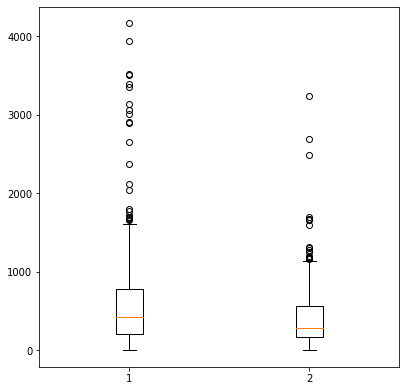

In [17]:
data_1 = data.loc[data['meal_class']==0, 'activity_aft'].values*1000
data_2 = data.loc[data['meal_class']==1, 'activity_aft'].values*1000
data_x = [data_1, data_2]
 
fig = plt.figure(figsize =(5, 5))
 
# Creating axes instance
ax = fig.add_axes([0,0,1,1])
 
# Creating plot
bp = ax.boxplot(data_x)
 
# show plot
plt.show()


import plotly.graph_objects as go


fig = go.Figure(layout = go.Layout(
            plot_bgcolor="#FFF",  # Sets background color to white
            xaxis=dict(
                linecolor="black",  # Sets color of X-axis line
                showgrid=False  # Removes X-axis grid lines
            ),
            yaxis=dict(
                title="post-meal step count",  
                linecolor="black",  # Sets color of Y-axis line
                showgrid=False,  # Removes Y-axis grid lines    
            ),
            font=dict(
                family="Helvetica",
                size=24,
                color="black"
            )
        ))
# fig.update_yaxes(range=[0, 101])
# fig.add_trace(go.Box(y=[50,50], boxpoints='all', text= descript[np.where(str_name == ty)[0]], boxmean=False, name=0))
for ty_x, ty in enumerate(['normal', 'elevated']):
    
    
   

        fig.add_trace(go.Box(y=data_x[ty_x], name=ty))



        
fig.show()

In [18]:
### data[data['cal']>10]

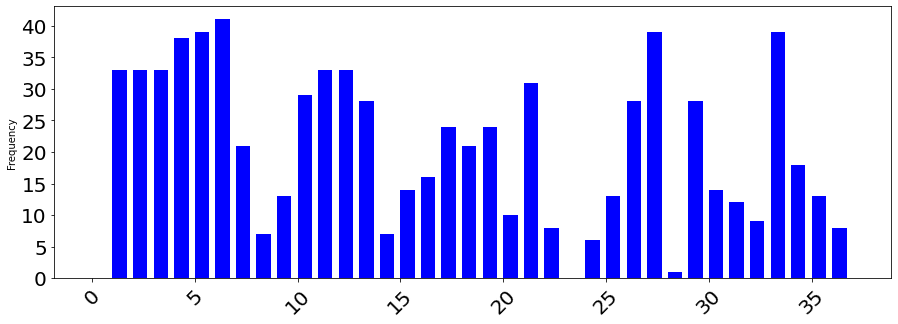

In [19]:
plt.figure(figsize=[15, 5])
data.uid.plot.hist(color='blue', bins=np.arange(0, 38, 1), width=0.7)
# plt.xlim([0, 400])
plt.xticks(fontsize= 20, rotation=45)
plt.yticks(fontsize= 20)
plt.savefig("/Users/amrutapai/Documents/SDRIpaper1/user_contri_pm.svg")
plt.show()

/var/folders/1_/q20zrcrs5q12qwr7qcs194nw0000gn/T/ipykernel_36306/1209026546.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



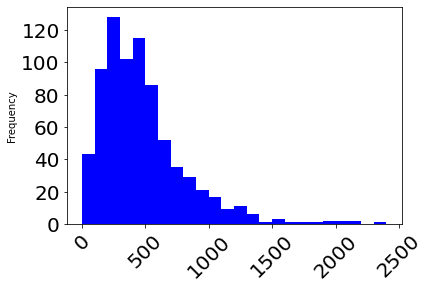

In [20]:
data['cal_100'] = data['cal'].values*100
data.cal_100.plot.hist(color='blue', bins=np.arange(0,2500, 100))
# plt.xlim([0, 400])
plt.xticks(fontsize= 20, rotation=45)
plt.yticks(fontsize= 20)
plt.savefig("/Users/amrutapai/Documents/SDRIpaper1/cal_pm.svg")
plt.show()

In [21]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [25]:
%%R -i data
library("cobalt")
covs <- subset(data, select = -c(activity_aft, a1c, auc, meal_class, uid))
bal.tab(covs, treat = data$activity_aft)

Balance Measures
        Type Corr.Un
cal  Contin. -0.0494
date Contin.  0.0741

Sample sizes
    Total
All   764


In [26]:
%%R -i data 
library(lmerTest)
m<-lmer('auc ~ (activity_aft) + cal + (1|uid)', data=data)
print(summary(m))
m1<-glmer("meal_class ~ activity_aft + cal + (1|uid)", data=data, family = 'binomial')
print(summary(m1))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: "auc ~ (activity_aft) + cal + (1|uid)"
   Data: data

REML criterion at convergence: 14229.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5687 -0.5678 -0.0911  0.4869  3.9212 

Random effects:
 Groups   Name        Variance Std.Dev.
 uid      (Intercept) 4837613  2199    
 Residual             6686231  2586    
Number of obs: 764, groups:  uid, 35

Fixed effects:
             Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)   4755.04     436.14   49.98  10.903 8.15e-15 ***
activity_aft  -640.63     185.44  740.10  -3.455 0.000582 ***
cal            182.80      33.95  756.95   5.384 9.71e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) actvt_
activity_ft -0.254       
cal         -0.388  0.082
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 F